# 1. Quaternion rate를 누적한 자세 추정

- 지구 회전을 고려하지 않을 경우 사용가능 다음과 같이 quaternion rate는 다음과 같이 단순화 하여 표현가능

$$
\begin{aligned}
{\dot q} &= \frac{1}{2}Q\tilde\omega^b\\\\
\begin{bmatrix}
\dot q_1\\
\dot q_2\\
\dot q_3\\
\dot q_4\\
\end{bmatrix}
&=
\frac{1}{2}
\begin{bmatrix}
q_1& -q_2& -q_3& -q_4\\
q_2& q_1& -q_4& q_3\\
q_3& q_4& q_1& -q_2\\
q_4& -q_3& q_2& q_1\\
\end{bmatrix}
\begin{bmatrix}
0\\
\omega_x\\
\omega_y\\
\omega_z\\
\end{bmatrix} \qquad (1) \\\\\\
\dot q &= \frac{1}{2}\Omega^b q\\\\
\begin{bmatrix}
\dot q_1\\
\dot q_2\\
\dot q_3\\
\dot q_4\\
\end{bmatrix}
&=
\frac{1}{2}
\begin{bmatrix}
0&-\omega_x&-\omega_y&-\omega_z\\
\omega_x&0&\omega_z&-\omega_y\\
\omega_y&-\omega_z&0&\omega_x\\
\omega_z&\omega_y&-\omega_x&0\\
\end{bmatrix}
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4
\end{bmatrix} \qquad (2)
\end{aligned}
$$
$$
\begin{aligned}
\\\\q_t&=q_{t-1} + \dot q T_s\\
q_t&=\frac{q_t}{||q_t||}\\
||q_t||&=\sqrt{q_1^2+q_2^2+q_3^2+q_4^2}
\end{aligned}
$$

- Quaternion에서 가장 중요한 부분은 quaternion 계산 후 
- (1)번식과 (2)번식을 사용한 quaternion accumulation을 사용한 orientation estimation의 결과는 동일하다.

## Program

In [1]:
import numpy as np
from scipy.io import loadmat
from math import sin, cos, tan
import matplotlib.pyplot as plt
from navimath import *

In [2]:
# Dataset selection
# f_number 
# 1: Example data provided by Magdwich
# 2: Real IMU data provided by Witmotion 
# 3: IMU data provided by Understanding Kalman filter
f_number = 2

if f_number == 1:
    # Example Data
    ExData1 = loadmat('..\Data\ExampleData.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    time = ExData1['time']
    Ts = time[1]-time[0]
    
    # System model noise covariance
    Q = np.zeros((4,4))
    Q[0, 0] = 1     # Roll angle uncertainty
    Q[1, 1] = 1     # Pitch angle uncertainty
    Q[2, 2] = 1     # Yaw angle uncertainity
    Q[3, 3] = 1     # Yaw angle uncertainity

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 0.01      # Accelerometer measurement uncertainty
    R[1, 1] = 0.01      # Accelerometer measurement uncertainty
    R[2, 2] = 0.01      # Magnetometer measurement uncertainity    
    R[3, 3] = 0.01      # Magnetometer measurement uncertainity    
    
    mu0 = np.array([1.0, 0.0, 0.0, 0.0])
    sigma0 = np.eye((4))
    
    Ts = time[1]-time[0]
    totalLen = Accelerometer.shape[0]
    
elif f_number ==2:

    # Example Data
    ExData1 = loadmat('..\Data\WitMotion_IMU_Data.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    Euler_Truth = ExData1['Euler']
    time = np.array([0, 1])
    Ts = time[1]-time[0]
  
    Q = np.zeros((4,4))
    Q[0, 0] = 1
    Q[1, 1] = 1
    Q[2, 2] = 1
    Q[3, 3] = 1

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 10
    R[1, 1] = 10
    R[2, 2] = 10
    R[3, 3] = 10
    
    mu0 = euler_to_quaternoin(Gyroscope[0,:])
    sigma0 = np.eye((4))
    
    Ts = 1
    totalLen = Accelerometer.shape[0]
    
else:
    ArsAccel = loadmat('..\Data\ArsAccel.mat')
    ArsGyro = loadmat('..\Data\ArsGyro.mat')
    
    Gyroscope = np.zeros((41500, 3))
    Accelerometer = np.zeros((41500, 3))
    
    Gyroscope[:,0] = ArsGyro['wx'][:,0]
    Gyroscope[:,1] = ArsGyro['wy'][:,0]
    Gyroscope[:,2] = ArsGyro['wz'][:,0]
    
    Accelerometer[:,0] = ArsAccel['fx'][:,0]
    Accelerometer[:,1] = ArsAccel['fy'][:,0]
    Accelerometer[:,2] = ArsAccel['fz'][:,0]    
    
    time = 0.01 * np.array([0, 1])
    Ts = time[1]-time[0]
        
    # System model noise covariance
    
    Q = np.zeros((4,4))
    Q[0, 0] = 0.0001
    Q[1, 1] = 0.0001
    Q[2, 2] = 0.0001
    Q[3, 3] = 0.0001

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 10
    R[1, 1] = 10
    R[2, 2] = 10
    R[3, 3] = 10
       

    mu0 = np.array([1.0, 0., 0., 0.])
    sigma0 = np.eye((4))
    
    Ts = 0.01
    totalLen = 41500

## (1)번 표현식 기준 quaternion 자세 계산

In [3]:
# (1) 번식을 기준으로 quaternion을 누적하여 자세를 구한다.

# 변수 초기화
q = np.array([1.0, 0.0, 0.0, 0.0]) # initial quaternion value

dot_q = np.zeros((4))
q_hist = np.zeros((totalLen, 4))
Euler_hist_q_radian = np.zeros((totalLen, 3))
Euler_hist_q_deg1 = np.zeros((totalLen, 3))

for i in range(totalLen):
#for i in range(2):    
    
    wx = Gyroscope[i, 0]
    wy = Gyroscope[i, 1]
    wz = Gyroscope[i, 2]
    wb = np.array([0.0, wx, wy, wz])
    
    q1 = q[0]
    q2 = q[1]
    q3 = q[2]
    q4 = q[3]       
    Q = np.array([[q1,-q2,-q3,-q4],[q2,q1,-q4,q3],[q3,q4,q1,-q2],[q4,-q3,q2,q1]])    
        
    # Quaternion rate
    dot_q = (1.0/2.0)*(np.matmul(Q, wb))    
    # Quaternion accumulation
    q = q + dot_q *Ts    
    # Quaternion normalization
    q = q/norm(q)  
    
    q_hist[i,:] = q
    Euler_hist_q_radian[i,:] = quaternion_to_euler(q)
    Euler_hist_q_deg1[i,:] = np.rad2deg(quaternion_to_euler(q))

## (2)번 표현식 기준 quaternion 자세 계산

In [4]:
# (2) 번식을 기준으로 
# 변수 초기화
q = np.array([1.0, 0.0, 0.0, 0.0]) # initial quaternion value

dot_q = np.zeros((4))
q_hist = np.zeros((totalLen, 4))
Euler_hist_q_radian = np.zeros((totalLen, 3))
Euler_hist_q_deg2 = np.zeros((totalLen, 3))

for i in range(totalLen):
    
    wx = Gyroscope[i, 0]
    wy = Gyroscope[i, 1]
    wz = Gyroscope[i, 2]
    
    Omega = np.array([[0.0,-wx, -wy, -wz],[wx, 0.0, wz, -wy],[wy, -wz, 0.0, wx],[wz, wy, -wx, 0.0]])    
    
    # Quaternion rate
    dot_q = (1.0/2.0)*(np.matmul(Omega, q))    
    # Quaternion accumulation
    q = q + dot_q *Ts    
    # Quaternion normalization
    q = q/norm(q)  
    
    q_hist[i,:] = q
    Euler_hist_q_radian[i,:] = quaternion_to_euler(q)
    Euler_hist_q_deg2[i,:] = np.rad2deg(quaternion_to_euler(q))

Text(0.5, 1.0, 'Attitude Estimation using Quaternion Accumulation with equation (2)')

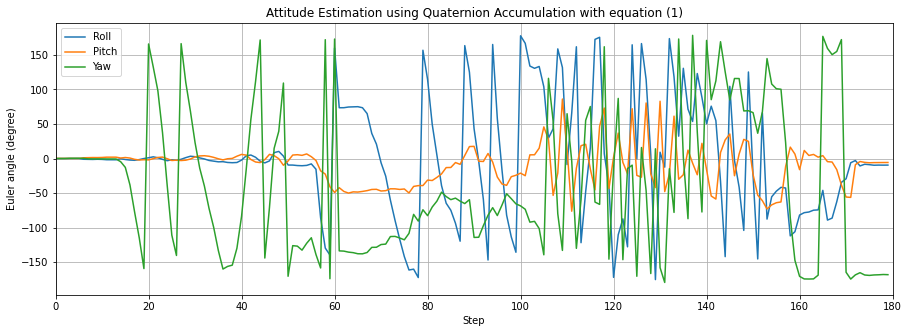

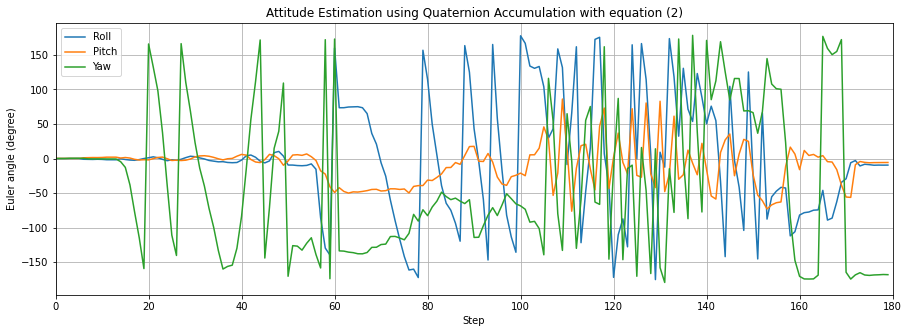

In [5]:
plt.figure(figsize=(15,5))
plt.plot(Euler_hist_q_deg1)
plt.legend(['Roll','Pitch','Yaw'])
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude Estimation using Quaternion Accumulation with equation (1)')


plt.figure(figsize=(15,5))
plt.plot(Euler_hist_q_deg2)
plt.legend(['Roll','Pitch','Yaw'])
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude Estimation using Quaternion Accumulation with equation (2)')